In [1]:
%matplotlib inline


==============================
Rescale, resize, and downscale
==============================

`Rescale` operation resizes an image by a given scaling factor. The scaling
factor can either be a single floating point value, or multiple values - one
along each axis.

`Resize` serves the same purpose, but allows to specify an output image shape
instead of a scaling factor.

Note that when down-sampling an image, `resize` and `rescale` should perform
Gaussian smoothing to avoid aliasing artifacts. See the `anti_aliasing` and
`anti_aliasing_sigma` arguments to these functions.

`Downscale` serves the purpose of down-sampling an n-dimensional image by
integer factors using the local mean on the elements of each block of the size
factors given as a parameter to the function.


In [4]:
import base64
import numpy as np
import io
import PIL
import re
import sys
from skimage.color import rgb2gray, rgba2rgb
np.set_printoptions(threshold=sys.maxsize)

In [5]:
import os
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\envs\\tfg\\python.exe'

In [6]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import resize

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization
import numpy as np
from time import time

In [8]:
# Dependencies to Visualize the model
# %matplotlib inline
from IPython.display import Image, SVG
# import matplotlib.pyplot as plt
import numpy as np
import os 
from os import listdir
from os.path import isfile, join

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image as image_processing
from IPython.display import Image as img_show

In [10]:
def decode_base64(data, altchars=b'+/'):
    """Decode base64, padding being optional.

    :param data: Base64 data as an ASCII byte string
    :returns: The decoded byte string.

    """
    data = re.sub(rb'[^a-zA-Z0-9%s]+' % altchars, b'', data)  # normalize
    missing_padding = len(data) % 4
    if missing_padding:
        data += b'='* (4 - missing_padding)
    return base64.b64decode(data, altchars)

In [11]:
string64= "iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AAAXgklEQVR4Xu2dOXNdRROGx9ZiUUVpDcggsSxZgZQSEZOhKkUOVFrslIyfQqi1HBCJEhk5EaFEFWiLICLQGlDW6q9G/i7I2u5Zumemzzw31UxPz9N9Xs125jx5//79e8cPAhCAgAECTxAsA1HCRQhA4JoAgkUiQAACZgggWGZChaMQgACCRQ5AAAJmCCBYZkKFoxCAAIJFDkAAAmYIIFhmQoWjEIAAgkUOQAACZgggWGZChaMQgACCRQ5AAAJmCCBYZkKFoxCAAIJFDkAAAmYIIFhmQoWjEIAAgkUOQAACZgggWGZChaMQgACCRQ5AAAJmCCBYZkKFoxCAAIJFDkAAAmYIIFhmQoWjEIAAgkUOQAACZgggWGZChaMQgACCRQ5AAAJmCCBYZkKFoxCAAIJFDkAAAmYIIFhmQoWjEIAAgkUOQAACZgggWGZCpe/omzdv3Nramjs+Pnbv37+v3OCTJ09cb2+vm5ycdAsLC66zs7OyLSpC4CYBBCuDfLi4uHBejNbX193JyUktMaqKCxGrSo56CFYGOSA1WtJE1dfXxyhME3ADbTPCMh5UC8JUFHF/f7+bmpq6nkbyg8B9BBAsY3nRJIF6CL2fPs7PzyNcxnIzhLsIVgjKNdvwIvX27Vt3dnZW05Kt6oODg25/f9+W03irSgDBUsVbzXgOo6iiZDo6OpzfNOAHAU8AwUokD/xDOTY25nZ3dxPxKB03/BTx6uoqHYfwJBoBBCsSekZR5cGPjIy4ra2t8hWp0RgCCFbAUOa6FiWN+PXr1yzIS0M1Yg/BChAoL1RLS0tRDmwG6F6UJliQj4I9eqMIlnIIenp63OnpqXIreZpnQT6/uCNYSjH/8ssv3a+//qpkHbMtAizI55ULCJZwvL/66iv3yy+/CFvF3GMEEK188gPBEor1ysrK9QvGl5eXQhYxU4YAolWGlt2yCJZA7L799lv3/fffC1jCRB0CrGnVoWejLoJVM06IVU2AwtXZPRQGmpg5BKtGQPw0cG5uroYFqmoQ4JyWBtU0bCJYNeLwxRdfuD///LOGBapqEahzY6qWT9itTwDBqsiQ0VVFcIGqsQgfCHTgZhCsisD9RXM//vhjxdp2qvkH398M+tDFeilcv/wQTUTLTp4V9RTBKkrqVrkmTAe7u7vdq1evxD8UkZKIIVoVEzzRaghWxcD4L8FYO3PVbrRUEUXbai0BW11dbVtWo8DTp0/NxUqDQxNsIlgVo5i6YKV6P3osbohWxURPrBqCVTEgqU0J/fRuenraxLUrQ0ND7uDgoCL56tW6urqyu2a6Oq00ayJYFeOSwqJ7qqOoIkj9a0yLi4tFioqWGRgYiCKWop3I2BiCVTH4MY41WBpFFcU6Ojrqtre3ixYXKee/yBNDLEWcz9wIglUjAUJMC3P52KhfYwp52DNkWzVSjKq3CCBYNVJCY5SV8zf5QooW98PXSPyIVRGsmvClXn7OWahuhiCkaDHKqpn8EaojWALQ64iWvxJldnbWxO6eAKpCJrx4h/gxygpBWbYNBEuIp58efvfdd4W/VOxHEv6mh4WFBSEPmmMm5A4ioyxbeYNgCcfLC5e/zO+33367c+Yn1klz4S4GMRfqrBZX0QQJp1gjCJYYSgxJEwhxKt6fZTs8PJR2HXtKBBAsJbCYlSGgvQjPy9EycQplBcEKRZp2KhPQFi3WsSqHJnhFBCs4chqsQkBzeohgVYlInDoIVhzutFqBgD8CcnV1VaHm41UQLHGkagYRLDW0GNYgoHFGi51CjUjp2ESwdLhiVYmAxsvS7BQqBUvBLIKlABWTugSkR1nsFOrGS9I6giVJE1tBCEgLlneadawgoavdCIJVGyEGQhNAsEITT6c9BCudWOBJQQIa57IYYRWEH7kYghU5ADRfnoC/5vjo6Kh8xUdqIFiiONWMIVhqaDGsRUDjNgcESytasnYRLFmeWAtEQHodC8EKFLiazSBYNQFSPQ4BBCsO99itIlixI0D7lQggWJWwma+EYJkPYZ4dkBYsXs+xkUcIlo044eUtAtKCxes5NlIMwbIRJ7xUFixez7GRYgiWjTjhpbJgefPsFKafZghW+jHCw3sISE8JESwbaYZg2YgTXt4iwOs5eaYEgpVn3M33mtdzzIewUgcQrErYqBSbgMZFfqxhxY5q+/YRrPaMKJEggWfPnt35UG1dNxGsugT16yNY+oxpQYEAi+4KUA2YRLAMBAkXPyagcVsDu4Q2sgzBshEnvLxBQGPBHcGykWIIlo044eUNAhrTQU6620gxBMtGnPDy/wQ0zl9507xLaCPFECwbccJL55yWWHm43NZgI8UQLBtxyt7Lzs5Od3l5qcaBIw1qaEUNI1iiODGmQWBoaMgdHBxomL622d3d7U5PT9XsY1iOAIIlxxJLCgS0jjDcdJXpoELglEwiWEpgMStDQHPdquUh00GZWIWwgmCFoEwblQiEGF0xHawUmmiVEKxo6Gm4HQGN9wVvtzkzM+NWVlbaucLfEyGAYCUSCNz4mMDFxYXr6upSx3J+fu78DiQ/GwQQLBtxys7Ljo4Od3V1pdrv4eFht7Ozo9oGxmUJIFiyPLEmQED7zJV3kVdxBAIVwQSCFQE6TT5MIMSuoG+doww2sxDBshm3RnodYhrowQ0ODrr9/f1GMmx6pxCspkfYSP/8ArtfaNf+eVEM0Y52P3K1j2DlGvmE+h1KrFi3SijoFV1BsCqCo5oMgVDTQMRKJl6xrSBYsSOQcfshdgNbeDlv1YxEQ7CaEUdzvQg1svJgeP3GXHo86DCC1ZxYmuhJiPcDb4PgCIOJ1CjkJIJVCBOFJAho32t1n4+sXUlELh0bCFY6sWi0JyHXq26CnJubc0tLS41mm1PnEKycoh2pr6FOr9/uHgdEIwVcsVkESxEupnU/HPEYX3+26+zsjBA0jACC1bCAptKdGIvrrb77EZ3mBytSYZyjHwhWjlFX7vPExITb3NxUbuV+84hVFOzBGkWwgqHOo6EYO4EtsuwINj/HEKzmxzhYD0MeBr3dKV5qDhbmqA0hWFHxN6PxmOtVniC7gc3IoyK9QLCKUKLMgwRiTgG9UyMjI25ra4sIZUIAwcok0NLd9HdK+Xf0Yn7Tz39V5927d9Jdw17CBBCshIOTqmuzs7NudXU1unsxxTJ65zN1AMHKNPBVuu1HVX19fe6ff/6pUl20Di80i+I0YwzBMhOqeI56oXr58qXb29uL58SNlsfHx93GxkYSvuBEWAIIVlje5lp78eKF293dTcZvxCqZUERxBMGKgj39RkdHR9329nYyjvoT7P7mhYWFhWR8wpHwBBCs8MyTbnF+ft4tLy8n5SPrVUmFI6ozCFZU/Gk13tPT405PT9NyqoQ3/tUcvykwNTXFSKwEN0tFESxL0VLyNcVRlXRXvZj19va6ycnJazHzFwrys0cAwbIXM1GPrY+qJGAgZhIUw9hAsMJwTq6VHEZVdaEzxaxLUL4+giXPNGmL/kzVp59+anqtKjZghCxeBBCseOyDt5zamargAJQa5AVsJbD3mEWwwrGO0pIfUY2NjSV1+DMKiACNcvxCHzKCpc84SgupvU4TBUKERrlBQhc6gqXLN4p1pn5RsH/UKNNEnRggWDpco1j1N3/6j4Zy7UoU/Pc2yjRRNhYIlizPaNZi3/wZreMGGuYKZ7kgIVhyLKNZ+uSTT7h5Mxr9Yg3zkYxinNqVQrDaEUr874ysEg/QDfcQrfqxQrDqM4xmIfbXaqJ13HDDTA/rBQ/Bqscvam1/RxQL7FFDUKlxFuIrYbuuhGBVZxe1JqOrqPhrN84/mmoIEaxq3KLXGhgYcEdHR9H9wIFqBIaHh93Ozk61yhnXQrCMBp/poNHA3XD7/Pyce7lKhhHBKgksleL+xgB+tgn4D9FavuE1Bn0EKwZ1gTYRLAGICZjw95ItLi4m4IkNFxAsG3G642XqgqV9Z5TfdFhbW3PHx8fmd0pZgC/+ECJYxVklVTKFNSz/wYcU70j3N1V4QVtfX3cnJyfJC5qP5eXlZVL5laozCFaqkWnjV4xdQr/mMj09bfqLNKmKmY/nwcGB0WwM5zaCFY61aEshz2HlcFVKClNM1rPaPyIIVntGyZbw76ZdXV2p+OfXoPwDlPuXlkN+Vcgz14qnSpJEMIpgRYAu1aTGKAuhuhsdDc4P5QCv7Tz+dCBYUuoRyc7ExITb3Nys3XoT1qdqQ2hjYHR01G1vb6s2w9ksBEs1wVIwXke0clifkoyRX7Tv6uqSNHnHFifgH8bLCEs19cIZ99OW5eXlwmsgCFX12GjfmT8zM+NWVlaqO9jgmghWw4L70G6X9kHOhmFs2x3Ng7v+fBsvtt8fAgSrbWpSAAJ3CWiuZ7FbyJSQZw4C4gQ0R1m8rsMISzxhMZg3Ac3jDiy8I1h5P130XoVAnR3axxx6/vy5293dVfHZslHWsCxHD9+TIKB1Gp5R1t3wIlhJpDxOWCagdTaL4w0IluXnAt8TJqCxAM/xBgQr4ZTHNcsENO4n43gDgmX5mcD3hAn09/df334q/WMd62OirGFJZxj2siQwOzvrVldXxfvObiGCJZ5UGISA1sK7J8so67/8YoTFswYBIQL+46h7e3tC1v4zw24hgiWeVBiEgNYoi91CBIunCwIqBDSON7BbiGCpJCtGIcBuoW4OsIalyxfrmRHQ2i1kHetDIiFYmT1QdFeXAOtYunwRLF2+WM+QgMZuIetYjLAyfJTocggCWqMsLvVjShgif2kjQwIau4V8sxDByvBRosshCGjsFnqbh4eHIdxPtg3WsJINDY5ZJqCxW8g6FiMsy88EvidMgHUsneAwwtLhilUIOI11rNwX3hEsHiwIKBHQuNQPwcqdgFKyYhYCAwMD4l9wzv1xZYTFcwUBJQIa3y1EsHInoJSsmIWAJyC9jpX748oIi+cKAooEECxZuAiWLE+sQeAjAgiWbEIgWLI8sQYBBEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDACEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDACEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDACEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDACEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDACEsxBxAsRbiYhgAjLNkcQLBkeWINAoywFHMAwVKEi2kIMMKSzQEES5Yn1iDwL4GnT5866U/LS9uzFi4Ey1rE8NcEgc7OTnd5eSnuK4KVOwHxlMJg7gSGhobcwcGBCobcH1dGWCpphdFcCbx588YtLi6qdR/Byp2AWmphOEcC0ovstxnm/rgywsrxqaLPKgQ0FtlvOurF8OrqSsV3K0YRLCuRws+kCWgtst/sdH9/vzs8PEyag7ZzCJY2Yew3noDmIvtNeK9fv3YLCwuN5/lYBxGsrMNP5+sS0F5kv+lf7utXngWCVTdjqZ81Ae1F9hbckZERt7W1lTVrBCv78AOgDoHR0VG3vb1dx0ThuoyuPqBihFU4ZSgIgY8JhBpdsXb1H3cEi6cQAhUIdHR0BDliMDg46Pb39yt42MwqCFYz40qvFAl0dXW5i4sLxRY+mPaiGKId9Y4INoBgCcLEVPMJdHd3u/Pzc/WOckj0fsQIlnrq0UBTCPjpWYiDm4jVwxmDYDXlaaIfqgT8wvfS0pJqGy3j7Ag2XLD84b2ff/7Z/f333//O+f2rEp999pn7+uuvsz8dHOQpa3gj7AimEWDTIywvVKurq20XJr14zczMIFxp5Jw5L7Rfam4BYUewfWqYFayJiQm3ubnZvoc3SoyPj7uNjY1SdSicN4FQYsW6VbE8MylYVcSqhQPRKpYYlHIulFh51qxbFcs4c4Il8bIpJ4eLJUfOpUJcF9PiOzc3F2xB33pMzQmWxAlj/59T4wMB1pMB/z8QCHVdjG/r2bNn7t27d6AvSMCUYEmMrlpcGGUVzJDMiknmWBF0TAWLUPqvjCnBkjy4NzAwoPZlk3IhoHRKBEIdX/B95p9m+cibEizJRVB2ZconS9Nr9PT0uNPT0yDdZPOnGmZTgiX934/heLWkaWKtkCfZEavqGYRgVWdHzQYRkP5n+BCaFy9eBLv0r0Hh+bcrWQsWawhNTOnyfZJcanisdXYEy8fmdo2sBctfFRJqzaJ+qLCgQUDimExRv1iCKErq4XJZC5bHQhLVTyKrFkJdxMeOoFyGZC9YfI1ELpksWQq5I8hLzXKZkb1gMcqSSyYrlkKKFdccy2aFKcHSWhxl8V02qVK2FlKsOOsnnwmmBMufTj86OhKnwOK7ONIkDYZcs0KsdFLAlGBpvufF4rtOgqViNeRuIGKlF3VTguUxaB3wY1qol2SxLWstJTzUL/756UXcnGD5w3dnZ2fiRJgWiiNNwmBoseJuK92wmxMspoW6CdEk66HFipPs+tljTrA0p4WsPegnXKgWQosVx2PCRNakYI2Ojqq+QMp6Vpjk02olhliRM1rR/NiuScHSHGW18HA6OUwCSrcSQ6zIFekoPmzPrGBpLb7fRMUp5XCJWKclv6759u1blc2Ydn6RI+0Iyf7drGBpLr4/hNivcfX19bmpqSk+yiqbh6WtXVxcuLGxMbe7u1u6rlQFxEqKZHE7ZgUrxLSwCEYvYr29vW5ycvJaxPznofjpEpifn3fLy8u6jbSxzjQwDn7TghViWlglLIhYFWrF6nz++efur7/+KlZYqRQL7EpgC5g1LVgxpoUFmD5YBCGrQ8+5kC8u3+cpx17qxU+itmnBSmVaWDUQz58/d3/88QfTyAIAY+z+3XaLV24KBEq5iHnBSnVaWDZujL7uEou5+3fbG6aBZTNap7x5wbI2LSwaRv9u4/T0dJa7kX5RfWVlJZnrq1lgL5q1+uXMC5ZHFPLqEP2Q3N9Ck49U+CMK/h/P+vq6Oz4+joX43nY5upBUOFwjBKupo6x2qdKaRn7zzTducXHRzFqYFyg/xfrpp5+SE6ibzFlkb5eB4f/eCMHy2CYmJtzm5mZ4ggm1mPIorDWK+uGHH6KcSC8bJsSqLLEw5RsjWIhWelNJayLVIohYhRGfKq00SrA8gFynh0WDH2IxP6XdvaJcEKuypOKUb5xgtTCmcG4nTkiLt1rnKIUXpbW1tes1qKacT2KBvXjuxCrZWMHyQIeGhtzBwUEstrRriAC3hdoIVqMFiymijSSM7SXnrGJHoHj7jRcspojFkyHHkuPj425jYyPHrpvsczaC5aPjr365vLw0GSiclifA6zbyTLUtZiVYrGtpp5MN+yMjI25ra8uGs3j5EYHsBKu1rrW0tNSY3S1yuj2BEMc52ntBiboEshSsFrQmbs3XTYim1ecQaLMimrVgPRZKxMx+onOuyn4Mb/cAwSoR05u3CpycnDClLMEudFGOKoQmHqY9BKsm55s3DyBiNWEKVWf3TwhkgmYQLKWgeCF7+fKl29vbU2oBs7cJsPvX/JxAsJRjzDRSFzC7f7p8U7OOYEWISAofAY3QbdEmh4eH3c7OjqhNjKVPAMGKHCN2I4sFoM7NEsVaoJQFAghWglFCxJxDoBJMzARcQrASCEIRF6ze3lmkb60yfj3q1atX118K8u998oPAbQIIltGcaMooDJEymoCR3EawIoHXaNbS1cR+0fz3339nJKWRCA22iWA1NLipjcBS/qJPQ1Ogkd1CsBoZ1rudCnEeDFHKJJkidhPBigifpiEAgXIEEKxyvCgNAQhEJIBgRYRP0xCAQDkCCFY5XpSGAAQiEkCwIsKnaQhAoBwBBKscL0pDAAIRCSBYEeHTNAQgUI4AglWOF6UhAIGIBBCsiPBpGgIQKEcAwSrHi9IQgEBEAghWRPg0DQEIlCOAYJXjRWkIQCAiAQQrInyahgAEyhFAsMrxojQEIBCRAIIVET5NQwAC5Qj8D1e1hDEKDtdGAAAAAElFTkSuQmCC"

In [12]:
base64_decoded =base64.b64decode(string64)

In [13]:
image64decode = PIL.Image.open(io.BytesIO(base64_decoded)).convert(mode="L").resize((28,28))
print(image64decode)

<PIL.Image.Image image mode=L size=28x28 at 0x20CA529F748>


In [14]:
image64decode.show()

In [17]:
image = 1- np.array(image64decode)/255
image

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.02745098,
        0.17647059, 0.34117647, 0.45490196, 0.47843137, 0.36470588,
        0.12156863, 0.    

In [18]:
# image = np.array(image64decode)

In [19]:
image.shape

(28, 28)

In [20]:
# grayscale = rgb2gray(rgba2rgb(image))

In [21]:
# grayscale.shape

In [22]:
# newarray = np.asarray(grayscale, dtype=np.float64)
# newarray.shape

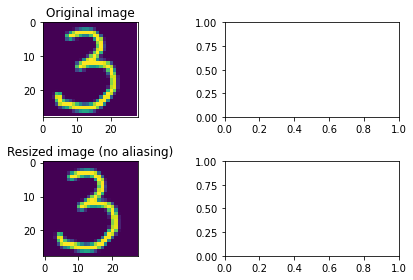

In [23]:
# image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (28,28), anti_aliasing=True)
# image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title("Original image")

# ax[1].imshow(image_rescaled, cmap='gray')
# ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized)
ax[2].set_title("Resized image (no aliasing)")

# ax[3].imshow(image_downscaled, cmap='gray')
# ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 28)
ax[0].set_ylim(28, 0)
plt.tight_layout()
plt.show()

In [24]:
# load the trained model
model = load_model("../Trained_Model/final_model.h5")

# recompile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
# define some colors for print-function
red = '\033[31m'
bolt = '\033[1m'
blu = '\033[34m'
prp = '\033[35m'
nc = '\033[0m'

def img_predict (base64string):
    base64_decoded =base64.b64decode(base64string)
    resize_GC_img = PIL.Image.open(io.BytesIO(base64_decoded)).convert(mode="L").resize((28,28))
    print(resize_GC_img)
    inverted_norm_array =  1 - np.asarray(resize_GC_img, dtype=np.float64)/255
    print(inverted_norm_array.shape)
    
    new_GC_etx = np.expand_dims(inverted_norm_array, axis=(3,0))
    print(new_GC_etx.shape)
    # con2v takes an array of 4 parameters, need to expand to add
    # additional dimension to the image

    
    # Invert the pixel values to highlight the features of the hand-written digit
    # as 0 x 0 = 0 => weight is not updated
    # pixel value of black (which is the digit ink pixel value) is 0
    # this would decrease performance (slower eight update) of CNN
    # therefore, inverted the grayscale to change the black pixel value
    # instead of 0 closer to 1 (after scaled by /=255)
    
#     print("before converstion :: \n", image)
#     print("after converstion :: \n", image)
    
    prediction = np.argmax(model.predict(new_GC_etx), axis=-1)
    return print(f"This is number :: {red}{bolt}{prediction[0]}{nc}\n{('=')*40}")

In [37]:
img_predict(string64)

<PIL.Image.Image image mode=L size=28x28 at 0x20CA54EBFC8>
(28, 28)
(1, 28, 28, 1)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02745098 0.17647059 0.34117647
  0.45490196 0.47843137 0.36470588 0.12156863 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.

This is number :: 3
